Tasks:
#### 1. Data preparation

- Download a translation dataset (pick a language pair) from https://www.manythings.org/anki/



- Alternatively, if you prefer, download morphological segmentation data from http://turing.iimas.unam.mx/wix/static/resources/language_data.tar.bz2. You can choose which language you want to work with or even try combining them. This dataset will likely be a bit faster to train than the MT one above. Also, one trick that has been shown to work on this type of data is to add in random strings that map to themselves, in order to teach the decoder to output mostly the same characters as it sees in the input (with the addition of the morpheme boundary characters).



- Create three .tsv files, one for each of train/dev/test partitions (if you use the MT data you will need to choose how to split the data, probably something like 70%/15%/15% would work). Once you have the data in this format, you smiply need to update the code in the "Load Data" section to load your data.


- For the NMT dataset, you may need to update the tokenization function depending on your language(s).


#### 2. Compare RNN Decoder (`Decoder` in the code) vs. RNN Decoder with Attention (`AttentionDecoder` in the code) 
- Read through the code for the Encoder, Attention, and the two Decoder classes. Make sure you have some understanding of what is going on before preceding.

- Train model (for ~50-100 epochs? more if time permits...) using the "Vanilla Decoder", which is the default.


- Make the necessary changes to the code (there should only be 2, there places are marked with a "TODO" comment) in order to run the same experiment with The AttentionDecoder.


- Compare the results (eg the validation loss). Do you notice any difference? For now, just look at the validation loss.


- Add to the `evaluate` function so that you also report a metric (you choose what metric). Alternatively for an easier task, complete the bleu-score function towards the end of the notebook.


#### 3. (Bonus 1) Implement Teacher Forcing
- Currently, in the `Seq2Seq` class's `forward()` method, there is a parameter called `teacher_forcing_ratio`, but we don't use it. "Teacher forcing" is a technique for training seq2seq models where, at each timestep, you give the decoder the correct output from the previous time step with some probability (instead of always feeding it the prediction from the previous time step, which might be wrong). Implement teacher forcing in this method. Assume `teacher_forcing_ratio` is a float between 0 and 1, and indicates the proportion of time we give the correct input to the decoder.

#### 4. (Bonus 2: pobably more relevant for the morphological segmentation corpus) Compare with RNN Transducer
- Train an RNN Transducer (from a few weeks ago) on the same data and compare the performances. 


<hr>

### NOTES:

To begin with...

1. If there is any import Error for Fields from torchtext.data, we would then need specific version of torchtext (0.8), please pip install requirements.txt which is present.

To pip install from colab notebook cell-

```
!pip install -r requirements.txt
```


2. ENG-DEU file download and train, val, test file creation-

```
!python eng_german_sample_download.py
```

In [2]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.9 MB 30.0 MB/s 
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.13.1
    Uninstalling torchtext-0.13.1:
      Successfully uninstalled torchtext-0.13.1


If there is OSError: ... so: undefined symbol: ... , please re-execute the cell.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.data import Field, TabularDataset, BucketIterator

import numpy as np

import random
import math
import time

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load Data
We will use utilities from the Pytorch package "torchtext" to easily load the data and batch it using buckets according to length (in order to minimize padding)

In [3]:
char_tokenize = lambda s: s.split()
SRC = Field(tokenize=char_tokenize, init_token='<sow>', eos_token='<eow>', lower=True)
TGT = Field(tokenize=char_tokenize, init_token='<sow>', eos_token='<eow>', lower=True)

/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [6]:
#
# TODO: Update this cell to load the dataset you chose. Once you have your data in 3 tsv 
# files (one per train/dev/test), just update the path and the names of the files.
#
path_to_data = "" # <give your data folder location here.>

train_data, val_data, test_data = TabularDataset.splits(
        path=path_to_data, train='train.tsv', # <your train.tsv file here>
        validation='val.tsv', # <your val.tsv file here>
        test='test.tsv', # <your test.tsv file here>
        format='tsv',
        fields=[('src', SRC), ('tgt', TGT)])

# If your dataset is huge and contains many unique words, then for the sake of fast execution, you can add this argument: min_freq = <some integer>
# Only tokens that appear atleast <some integer> times then are considered. Other such words are replaced by < UNK >

SRC.build_vocab(train_data)
TGT.build_vocab(train_data)

/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


In [8]:
print(f"Unique tokens in source (pam) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TGT.vocab)}")

Unique tokens in source (pam) vocabulary: 1268
Unique tokens in target (en) vocabulary: 1464


In [9]:
################################################################################################
# TODO: play with the batch size. Depending on your machine and dataset you may be able to get #
# away with much larger batches.                                                               #
################################################################################################
BATCH_SIZE = 8 

(train_iterator, valid_iterator, test_iterator) = BucketIterator.splits(
    (train_data, val_data, test_data),
    batch_size=BATCH_SIZE,
    device=device,
    sort_key=lambda x: len(x.src) # batch by length in order to minimize sequence padding
)

/usr/local/lib/python3.7/dist-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


## Define Model (Encoder, Decoder, Attention Layer, and Decoder with Attention)
We define both a "standard" decoder and an attention decoder, so that we can evaluate the impact of attention

### Encoder

In [10]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):        
        embedded = self.dropout(self.embedding(src))     
        outputs, hidden = self.rnn(embedded)
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        return outputs, hidden

### Vanilla Decoder (no attention mechanism)

In [11]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, dec_hid_dim, dropout):
        super().__init__()
        self.output_dim = vocab_size
        self.hid_dim = dec_hid_dim
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.rnn = nn.GRU(emb_dim, dec_hid_dim)
        self.fc_out = nn.Linear(dec_hid_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden):
        #
        # On the first time step, the hidden tensor 
        # (the context vector from the encoder) is only 2d, 
        # so we unsqueeze it.
        #
        if len(hidden.shape) == 2:
            hidden = hidden.unsqueeze(0)
            
        input = input.unsqueeze(0)        
        embedded = self.dropout(self.embedding(input))                
        outputs, hidden = self.rnn(embedded, hidden)
        prediction = self.fc_out(outputs.squeeze(0)) 
        # last value returned is for attention. Since vanilla model doesn't have attention, this value is None.       
        return prediction, hidden, None



### Attention

In [12]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #
        # Repeat decoder hidden state src_len times in order to concatenate it 
        # with the encoder outputs.
        #
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        # energy shape: [batch size, src len, dec hid dim]
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2)))
        # attention shape: [batch size, src len]
        attention = self.v(energy).squeeze(2)
        
        return F.softmax(attention, dim=1)

### Decoder with Attention

In [13]:
class AttentionDecoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(0)
        embedded = self.dropout(self.embedding(input))
        
        a = self.attention(hidden, encoder_outputs) 
        a = a.unsqueeze(1)
                
        #
        # Get weighted sum of encoder states (weighted by attention vector)
        #
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        weighted = torch.bmm(a, encoder_outputs)
        weighted = weighted.permute(1, 0, 2)
                
        rnn_input = torch.cat((embedded, weighted), dim = 2)            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #
        # Also feed the input embedding and the attended encoder representation 
        # to the fully connected output layer.
        #
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
                
        return prediction, hidden.squeeze(0), a.squeeze(1)

## Putting it all together (the Seq2Seq model)

In [15]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]

        
        for t in range(1, trg_len):
            
            ################################################################## #
            # TODO*: change to accomodate the AttentionDecoder forward() call.  #
            #       You will also need to change a line in the next cell (look # 
            #       for asterisk)
            ##################################################################
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs)   

            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 

            #################################################################
            # TODO: (Bonus task) implement teacher forcing here             #
            #################################################################
            input = trg[t]



        return outputs

## Training Logic

In [16]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TGT.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)

###################################################################################################
# TODO*:                                                                                           #
# The following line defines the decoder as a Vanilla RNN (GRU) Decoder (i.e. no attention).      #
# Your task is to update this line to use the Bahdanau decoder (AttentionDecoder). You will       #
# need to check out the __init__ method of AttentionDecoder to make sure you are passing it the   #
# appropriate args.                                                                               #
###################################################################################################

dec = AttentionDecoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)


model = Seq2Seq(enc, dec, device).to(device)

def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(1268, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): AttentionDecoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(1464, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=1464, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [17]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    print("Starting training...")
    for i, batch in enumerate(iterator):
        src = batch.src
        trg = batch.tgt
        optimizer.zero_grad()
        output = model(src, trg, 0.5)  # use teacher forcing during training only.
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)        
        
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [18]:
def evaluate(model, iterator, criterion):
    model.eval()

    epoch_loss = 0    
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src = batch.src
            trg = batch.tgt
            output = model(src, trg, 0) # turn off teacher forcing   
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)
            loss = criterion(output, trg)
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [19]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [20]:
N_EPOCHS = 150
CLIP = 1
optimizer = optim.Adam(model.parameters(), lr=0.001)
TRG_PAD_IDX = TGT.vocab.stoi[TGT.pad_token]
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

train_losses, val_losses = [], []

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut3-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')
    

Starting training...


/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch: 01 | Time: 0m 3s
	Train Loss: 6.037
	 Val. Loss: 5.442
Starting training...
Epoch: 02 | Time: 0m 2s
	Train Loss: 5.006
	 Val. Loss: 5.222
Starting training...
Epoch: 03 | Time: 0m 2s
	Train Loss: 4.455
	 Val. Loss: 5.125
Starting training...
Epoch: 04 | Time: 0m 2s
	Train Loss: 3.926
	 Val. Loss: 5.236
Starting training...
Epoch: 05 | Time: 0m 2s
	Train Loss: 3.367
	 Val. Loss: 5.288
Starting training...
Epoch: 06 | Time: 0m 2s
	Train Loss: 2.799
	 Val. Loss: 5.400
Starting training...
Epoch: 07 | Time: 0m 2s
	Train Loss: 2.280
	 Val. Loss: 5.585
Starting training...
Epoch: 08 | Time: 0m 2s
	Train Loss: 1.789
	 Val. Loss: 5.890
Starting training...
Epoch: 09 | Time: 0m 2s
	Train Loss: 1.371
	 Val. Loss: 5.944
Starting training...
Epoch: 10 | Time: 0m 2s
	Train Loss: 1.013
	 Val. Loss: 6.205
Starting training...
Epoch: 11 | Time: 0m 2s
	Train Loss: 0.741
	 Val. Loss: 6.443
Starting training...
Epoch: 12 | Time: 0m 2s
	Train Loss: 0.544
	 Val. Loss: 6.688
Starting training...
Epoc

## Inference

The following blocks are only valid for attention model. If you are executing Vanilla Decoder, then stop here!



We are now going to machine translate some sentences using our trained attention model.

The function takes in sentence to translate, SRC, TGT fields and the model and returns predicted sentence and attention values over the sequence.

In [21]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len=50):
    model.eval()

    tokens = [token.lower() for token in sentence]
    # Add start of sentence and end of sentence to the tokens
    tokens = [src_field.init_token] + tokens + [src_field.eos_token]

    # Numericalize the source sentence
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    # src_indexes shape = [src_len]

    # Convert to tensor and add batch dimension.
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    # Feed source sentence into encoder
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor)
    
    # create a list to hold the output sentence, initialized with an <sos> token
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    # create a tensor to hold the attention values
    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)

    for i in range(max_len):
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs)
        attentions[i] = attention
        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]

    return trg_tokens[1:], attentions[:len(trg_tokens)-1]

Function to display attention visualization

In [22]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                       rotation=45)
    ax.set_yticklabels(['']+translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

### Inference on some test sentences

In [44]:
example_idx = 4

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['tgt']

print(f'src = {src}')
print(f'trg = {trg}')

src = ["let's", 'not', 'go.']
trg = ['e', 'támu', 'púpuntá.']


In [45]:
translation, attention = translate_sentence(src, SRC, TGT, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['éku', 'mámangán.', '<eow>']


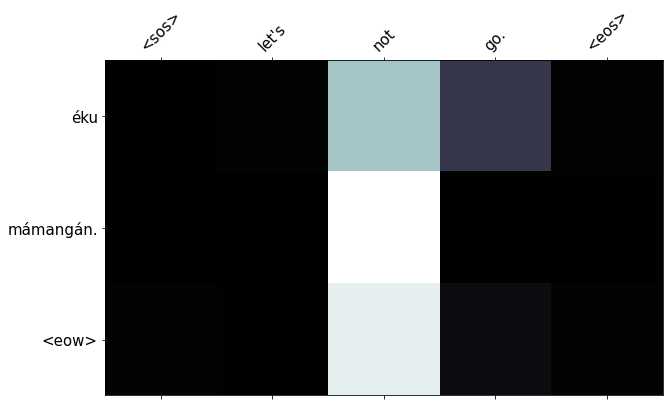

In [49]:
display_attention(src, translation, attention)

### Bleu score calculation on test set

In [47]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        tgt = vars(datum)['tgt']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([tgt])

        return bleu_score(pred_trgs, trgs)

In [48]:
bleu_score = calculate_bleu(test_data, SRC, TGT, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 0.00
